In [1]:
# Import libraries to use 
import numpy as np
import matplotlib.pyplot as plt
import math       
import scipy as sp
import scipy.optimize
import subprocess # Library to run ngspice on shell
import seaborn as sns # Library to change the color palette for plots
import random
import timeit # To time computing time
import warnings # To supress warnings
import string

# Introducing contact resistance between 2 tapes

- In this model we consider two tapes 1 m long divided in three sections.
- Electric field criterion for ngspice model is 100 microV/m

In [18]:
def readdata(filename):
    out = subprocess.run(['ngspice', '-b', filename], 
                         stdout=subprocess.PIPE,  stderr=subprocess.PIPE)
    
    name = filename[:-4]+'.txt' # Name of the file to save output from ngspice
    
    # This saves output data in txt file
    with open(name, 'w') as output:
        for line in out.stdout.decode('ascii').split('\n'):
            output.write(line+'\n') # Writing output lines 
    
    # We get the data into an array 
    fill = np.zeros (len(Labels), dtype=int)
    
    f = open (name, 'r');
    src = []
    while True:  
        line = f.readline()
        if not line: break  # end of file
        if line[0] == '#':
            continue # treat next line
        src.append(line)

    #print(src)

    for line in src:
        #print line
        # Here we initialize the ngspice data array
        if line.startswith('No.'):
            temp_list = line.split(":")
            Data_points = int(temp_list[-1])
            #print(Data_points)
            data = np.zeros ([Data_points, len(Labels)])
            #print(data.shape)


        # Here we determine the indexes for the current columns
        if line.startswith('Index'):
            temp_list = [str(x) for x in line.split()]
            #print(temp_list)
            n_columns = len (temp_list)
            index = np.zeros(n_columns, dtype = int)

            for j in range(n_columns):
                index [j] = Labels.index(temp_list[j])
            #print index

        # if the line starts with a number, we treat it as the data line
        if line[0].isdigit():
            temp_data = [float(x) for x in line.split()]

            for c in range(n_columns):
                r = fill[c]
                #print(r, index [c])

                data [r][index[c]] = temp_data [c]

                fill [c] = fill [c] + 1
                if fill [c] == Data_points:
                    fill [c] = 0
    return data

# Tapes divided in three sections: comparing short and open contact

<img src="3 sections.png">

In [14]:
# Definitions

# Function to generate netlist for ngspice
def generatenetlist(filename,Rc):
    Imax = 250
    Ic1 = 100
    Ic2 = 50
    Rt = 5E-7
    n = 30
    with open(filename, 'w') as output:
        output.write(f'* Netlist for 2 tapes with contact resistance\n') # Name of the circuit as a comment
        output.write('I1 0 N001 100\n') # Current source
        output.write(f'rt_i_1 N002 N001 {Rt/2}\n')
        output.write(f'rt_i_2 N006 N001 {Rt/2}\n')
        output.write(f'rt_f_1 0 N005 {Rt/2}\n')
        output.write(f'rt_f_2 N009 0 {Rt/2}\n')
        output.write(f'r1 N006 N002 {Rc}\n')
        output.write(f'r2 N007 N003 {Rc}\n')
        output.write(f'r3 N008 N004 {Rc}\n')
        output.write(f'r4 N009 N005 {Rc}\n')
        output.write(f'b1 N002 N003 V=33E-6*pow((I(b1)/{Ic1}),{n})\n')
        output.write(f'b2 N003 N004 V=33E-6*pow((I(b2)/{Ic1}),{n})\n')
        output.write(f'b3 N004 N005 V=33E-6*pow((I(b3)/{Ic1}),{n})\n')
        output.write(f'b4 N006 N007 V=33E-6*pow((I(b4)/{Ic2}),{n})\n')
        output.write(f'b5 N007 N008 V=33E-6*pow((I(b5)/{Ic2}),{n})\n')
        output.write(f'b6 N008 N009 V=33E-6*pow((I(b6)/{Ic2}),{n})\n')
        output.write('.options savecurrents\n')
        output.write(f'.dc I1 0 {Imax} 1\n')
        #output.write('.print dc  V(n001) I(B1)\n')
        #output.write('.print dc V(n001) @r1[i] @r2[i] @r3[i] @r4[i] @b1[i] @b2[i] @b3[i] @b4[i] @b5[i] @b6[i]\n')
        output.write('.print dc v(n001) @r1[i] @r2[i] @r3[i] @r4[i] @b1[i] @b2[i] @b3[i] @b4[i] @b5[i] @b6[i]\n')
        output.write('.end\n')

['Index', 'i-sweep', 'v(n001)', '@r1[i]', '@r2[i]', '@r3[i]', '@r4[i]', '@b1[i]', '@b2[i]', '@b3[i]', '@b4[i]', '@b5[i]', '@b6[i]']


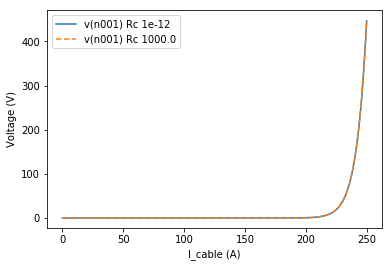

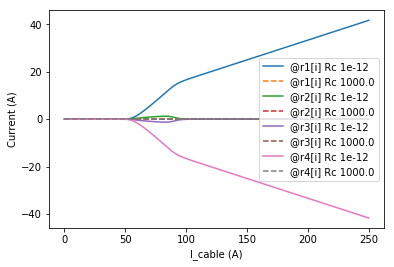

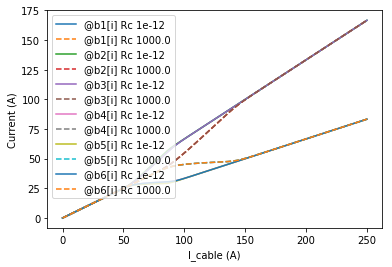

In [39]:
# Printing the labels of the elements to read current for this case
Labels = ['Index','i-sweep','v(n001)']
num_resistances = 4
num_vsources = 6
for i in range(num_resistances):
    Labels.append(f'@r{i+1}[i]')
for i in range(num_vsources):
    Labels.append(f'@b{i+1}[i]')
    
print(Labels)
#print(*Labels[2:], sep=' ')


# Testing different values of contact resistance
Rc = np.array([1E-12,1000])

# Generating netlists and saving data
for i in range(len(Rc)):
    filename = f'Rc {Rc[i]}.cir'
    generatenetlist(filename,Rc[i])
    #Icable,Vt,IR1,IR2,IR3,IR4,IB1,IB2,IB3,IB4,IB5,IB6 = gettingdata(filename)
    if i == 0:
        data1 = readdata(filename)
        #print('data1')
        #print(data1)
    if i == 1:
        data2 = readdata(filename)
        #print('data2')
        #print(data2)


# Plotting data for two cases
Icable1 = data1[:,1]
Icable2 = data2[:,1]

plt.plot(Icable1,data1[:,2],label = Labels[2]+f' Rc {Rc[0]}')
plt.plot(Icable2,data2[:,2],'--',label = Labels[2]+f' Rc {Rc[1]}')
plt.xlabel('I_cable (A)')
plt.ylabel('Voltage (V)')
plt.legend()
plt.show()

for i in range(num_resistances):
    plt.plot(Icable1,data1[:,i+3],label = Labels[i+3]+f' Rc {Rc[0]}')
    plt.plot(Icable2,data2[:,i+3],'--',label = Labels[i+3]+f' Rc {Rc[1]}')
plt.xlabel('I_cable (A)')
plt.ylabel('Current (A)')
plt.legend()
plt.show()

for i in range(num_vsources):
    plt.plot(Icable1,data1[:,i+7],label = Labels[i+7]+f' Rc {Rc[0]}')
    plt.plot(Icable2,data2[:,i+7],'--',label = Labels[i+7]+f' Rc {Rc[1]}')
plt.xlabel('I_cable (A)')
plt.ylabel('Current (A)')
plt.legend()
plt.show()


<IPython.core.display.Javascript object>


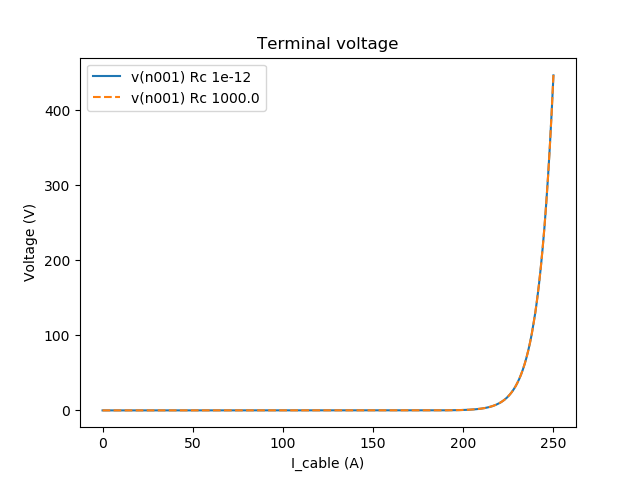

In [28]:
%matplotlib notebook

# Plotting data for two cases
Icable1 = data1[:,1]
Icable2 = data2[:,1]

plt.plot(Icable1,data1[:,2],label = Labels[2]+f' Rc {Rc[0]}')
plt.plot(Icable2,data2[:,2],'--',label = Labels[2]+f' Rc {Rc[1]}')
plt.xlabel('I_cable (A)')
plt.ylabel('Voltage (V)')
plt.title('Terminal voltage')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


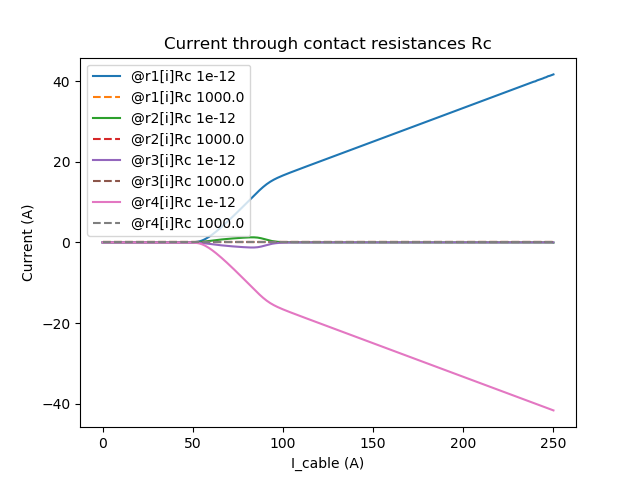

In [25]:
%matplotlib notebook
# Current through contact resistances 
for i in range(num_resistances):
    plt.plot(Icable1,data1[:,i+3],label = Labels[i+3]+f' Rc {Rc[0]}')
    plt.plot(Icable2,data2[:,i+3],'--',label = Labels[i+3]+f' Rc {Rc[1]}')
plt.xlabel('I_cable (A)')
plt.ylabel('Current (A)')
plt.title('Current through contact resistances Rc')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


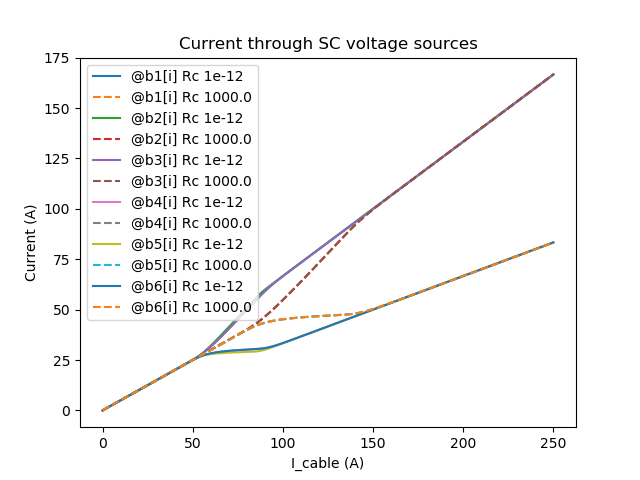

In [29]:
%matplotlib notebook
for i in range(num_vsources):
    plt.plot(Icable1,data1[:,i+7],label = Labels[i+7]+f' Rc {Rc[0]}')
    plt.plot(Icable2,data2[:,i+7],'--',label = Labels[i+7]+f' Rc {Rc[1]}')
plt.xlabel('I_cable (A)')
plt.ylabel('Current (A)')
plt.title('Current through SC voltage sources')
plt.legend()
plt.show()



# Tape considering only one section

<img src="1 section.png">

In [40]:
# Function to generate netlist for ngspice
def generatenetlist_onesection(filename,Rc):
    Imax = 250
    Ic1 = 100
    Ic2 = 50
    Rt = 5E-7
    n = 30
    with open(filename, 'w') as output:
        output.write(f'* Netlist for 2 tapes with contact resistance\n') # Name of the circuit as a comment
        output.write('I1 0 N001 100\n') # Current source
        output.write(f'rt_i_1 N002 N001 {Rt/2}\n')
        output.write(f'rt_i_2 N004 N001 {Rt/2}\n')
        output.write(f'rt_f_1 0 N003 {Rt/2}\n')
        output.write(f'rt_f_2 0 N005 {Rt/2}\n')
        output.write(f'r1 N002 N004 {Rc}\n')
        output.write(f'r2 N003 N005 {Rc}\n')
        output.write(f'b1 N002 N003 V=100E-6*pow((I(b1)/{Ic1}),{n})\n')
        output.write(f'b2 N004 N005 V=100E-6*pow((I(b2)/{Ic2}),{n})\n')
        output.write('.options savecurrents\n')
        output.write(f'.dc I1 0 {Imax} 1\n')
        #output.write('.print dc  V(n001) I(B1)\n')
        #output.write('.print dc V(n001) @r1[i] @r2[i] @r3[i] @r4[i] @b1[i] @b2[i] @b3[i] @b4[i] @b5[i] @b6[i]\n')
        output.write('.print dc v(n001) @r1[i] @r2[i] @b1[i] @b2[i]\n')
        output.write('.end\n')
        
        

['Index', 'i-sweep', 'v(n001)', '@r1[i]', '@r2[i]', '@b1[i]', '@b2[i]']


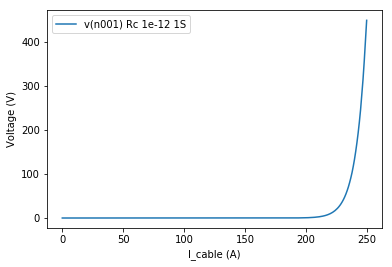

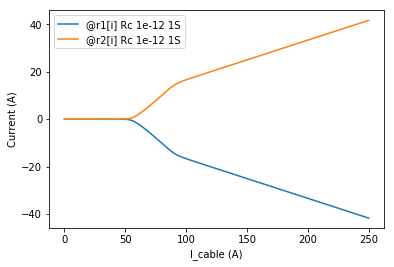

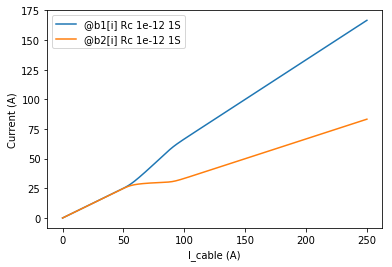

In [41]:
%matplotlib inline

# Printing the labels of the elements to read current for this case
Labels = ['Index','i-sweep','v(n001)']
num_resistances = 2
num_vsources = 2
for i in range(num_resistances):
    Labels.append(f'@r{i+1}[i]')
for i in range(num_vsources):
    Labels.append(f'@b{i+1}[i]')
    
print(Labels)
#print(*Labels[2:], sep=' ')


# Testing different values of contact resistance
Rc = np.array([1E-12])

# Generating netlists and saving data
for i in range(len(Rc)):
    filename = f'1s-Rc {Rc[i]}.cir'
    generatenetlist_onesection(filename,Rc[i])
    #Icable,Vt,IR1,IR2,IR3,IR4,IB1,IB2,IB3,IB4,IB5,IB6 = gettingdata(filename)
    if i == 0:
        data1 = readdata(filename)
        #print('data1')
        #print(data1)

#data2 = readdata(f'Rc {Rc[0]}.cir')



# Plotting data for two cases
Icable1 = data1[:,1]
#Icable2 = data2[:,1]

plt.plot(Icable1,data1[:,2],label = Labels[2]+f' Rc {Rc[0]} 1S')
#plt.plot(Icable2,data2[:,2],'--',label = Labels2[2]+f' Rc {Rc[0]} 3S')
plt.xlabel('I_cable (A)')
plt.ylabel('Voltage (V)')
plt.legend()
plt.show()

for i in range(num_resistances):
    plt.plot(Icable1,data1[:,i+3],label = Labels[i+3]+f' Rc {Rc[0]} 1S')
    #plt.plot(Icable2,data2[:,i+3],'--',label = Labels2[i+3]+f' Rc {Rc[0]} 3S')
plt.xlabel('I_cable (A)')
plt.ylabel('Current (A)')
plt.legend()
plt.show()

for i in range(num_vsources):
    plt.plot(Icable1,data1[:,i+5],label = Labels[i+5]+f' Rc {Rc[0]} 1S')
    #plt.plot(Icable2,data2[:,i+7],'--',label = Labels[i+7]+f' Rc {Rc[0]} 3S')
plt.xlabel('I_cable (A)')
plt.ylabel('Current (A)')
plt.legend()
plt.show()

